In [31]:
import json
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import io

from sklearn.decomposition import PCA


### Загрузка и подготовка данных

In [32]:
file_ = io.TextIOWrapper(open('lesson_4.json', 'rb'), 'windows-1251')

# TextIOWrapper позволяет открывать данные в нужной кодировке (здесь это windows-1251).

In [33]:
df = pd.read_json(file_)
df.head(2)

,global_id,ID,TypeObject,NameOwner,OnTerritoryOfMoscow,AdmArea,District,Location,Longitude_WGS84,Latitude_WGS84,StationInfo,geoData,geodata_center
0,1031191969,71,здание/сооружение,Государственное бюджетное профессиональное обр...,да,Центральный административный округ,район Замоскворечье,"город Москва, Пятницкая улица, дом 46, строение 3",37.627300,55.736850,"[{'BaseStation': '4039', 'Operator': 'ПАО «Вым...","{'coordinates': [37.6273, 55.73685], 'type': '...","{'type': 'geometry', 'value': '0101000000F163C..."
1,1031191971,73,здание/сооружение,Государственное бюджетное учреждение здравоохр...,да,Центральный административный округ,Пресненский район,"город Москва, Садовая-Кудринская улица, дом 15...",37.584398,55.765119,"[{'BaseStation': '28', 'Operator': 'ПАО «Мобил...","{'coordinates': [37.584398, 55.765119], 'type'...","{'type': 'geometry', 'value': '010100000085ECB..."


In [4]:
df["Operator"] = df.apply(lambda row: row["StationInfo"][0]["Operator"], axis = 1)
df["Base_station"] = df.apply(lambda row: row["StationInfo"][0]["BaseStation"], axis = 1)

del df["ID"]
del df["OnTerritoryOfMoscow"]
del df["StationInfo"]
del df["geoData"]
del df["geodata_center"]

df.rename(columns={"Longitude_WGS84": "Longitude", "Latitude_WGS84": "Latitude"}, inplace = True)

In [5]:
df.head(2)

,global_id,TypeObject,NameOwner,AdmArea,District,Location,Longitude,Latitude,Operator,Base_station
0,1031191969,здание/сооружение,Государственное бюджетное профессиональное обр...,Центральный административный округ,район Замоскворечье,"город Москва, Пятницкая улица, дом 46, строение 3",37.627300,55.736850,ПАО «ВымпелКом»,4039
1,1031191971,здание/сооружение,Государственное бюджетное учреждение здравоохр...,Центральный административный округ,Пресненский район,"город Москва, Садовая-Кудринская улица, дом 15...",37.584398,55.765119,ПАО «Мобильные ТелеСистемы»,28


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6606 entries, 0 to 6605
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   global_id     6606 non-null   int64  
 1   TypeObject    6606 non-null   object 
 2   NameOwner     6606 non-null   object 
 3   AdmArea       6606 non-null   object 
 4   District      6606 non-null   object 
 5   Location      6606 non-null   object 
 6   Longitude     6606 non-null   float64
 7   Latitude      6606 non-null   float64
 8   Operator      6606 non-null   object 
 9   Base_station  6606 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 516.2+ KB


In [10]:
df["AdmArea"].fillna("NA", inplace = True)
df["District"].fillna("NA", inplace = True)

In [11]:
set(df["Operator"])

{'ANT',
 'ООО «Антарес»',
 'ООО «Т2 Мобайл»',
 'ПАО «ВымпелКом»',
 'ПАО «МегаФон»',
 'ПАО «Мобильные ТелеСистемы»'}

In [12]:
# закодируем (пронумеруем) операторов

df["Operator"] = df["Operator"].map({'ANT': 0, 'ООО «Антарес»': 1, 'ООО «Т2 Мобайл»': 2, 'ПАО «ВымпелКом»': 3, 'ПАО «МегаФон»': 4, 'ПАО «Мобильные ТелеСистемы»': 5 })

In [13]:
df.head(3)

,global_id,TypeObject,NameOwner,AdmArea,District,Location,Longitude,Latitude,Operator,Base_station
0,1031191969,здание/сооружение,Государственное бюджетное профессиональное обр...,Центральный административный округ,район Замоскворечье,"город Москва, Пятницкая улица, дом 46, строение 3",37.627300,55.736850,3,4039
1,1031191971,здание/сооружение,Государственное бюджетное учреждение здравоохр...,Центральный административный округ,Пресненский район,"город Москва, Садовая-Кудринская улица, дом 15...",37.584398,55.765119,5,28
2,1031191972,здание/сооружение,Государственное бюджетное общеобразовательное ...,Центральный административный округ,Красносельский район,"город Москва, Скорняжный переулок, дом 3, стро...",37.643076,55.773386,4,1236


### Построение базовой модели

In [14]:
coordinates = np.array([[row['Longitude'], row['Latitude']] for index, row in df.iterrows()])

In [15]:
coordinates

array([[37.6273  , 55.73685 ],
       [37.584398, 55.765119],
       [37.643076, 55.773386],
       ...,
       [37.689585, 55.777495],
       [37.34887 , 55.842974],
       [37.34154 , 55.845021]])

In [16]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

KMeans(n_clusters=5)

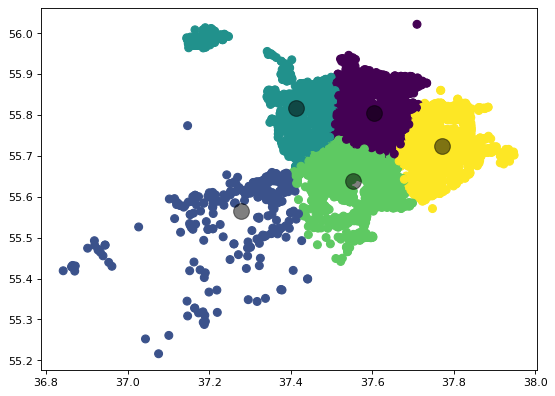

In [17]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


#### Посмотрим по каждому оператору

Text(0.5, 1.0, 'ООО «Т2 Мобайл»')

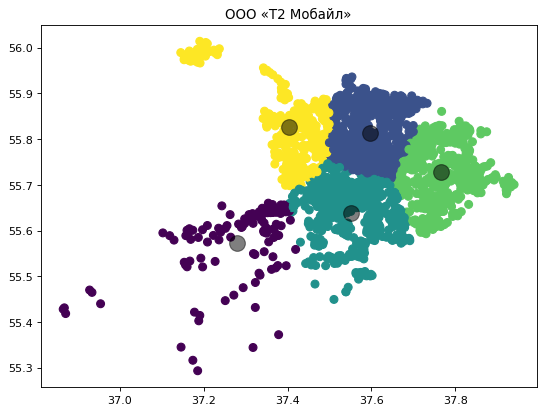

In [18]:
df_operator = df[df["Operator"] == 2]

coordinates = np.array([[row['Longitude'], row['Latitude']] for index, row in df_operator.iterrows()])

kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("ООО «Т2 Мобайл»")


Text(0.5, 1.0, 'ПАО «ВымпелКом»')

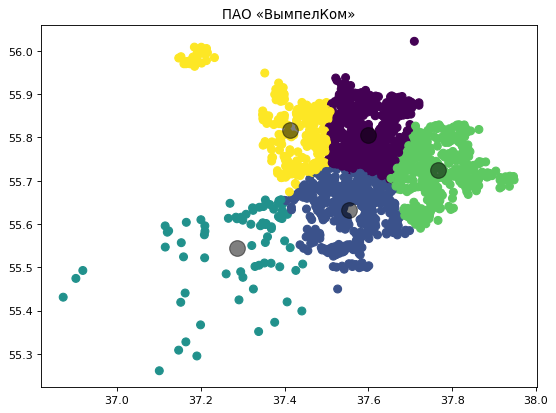

In [19]:
df_operator = df[df["Operator"] == 3]

coordinates = np.array([[row['Longitude'], row['Latitude']] for index, row in df_operator.iterrows()])

kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title("ПАО «ВымпелКом»")

Text(0.5, 1.0, 'ПАО «МегаФон»')

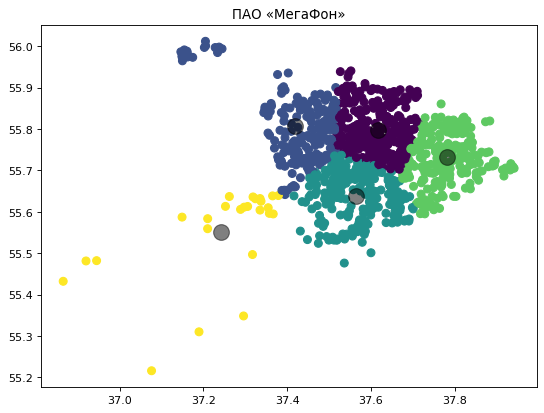

In [20]:
df_operator = df[df["Operator"] == 4]

coordinates = np.array([[row['Longitude'], row['Latitude']] for index, row in df_operator.iterrows()])

kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title("ПАО «МегаФон»")

Text(0.5, 1.0, 'ПАО «Мобильные ТелеСистемы»')

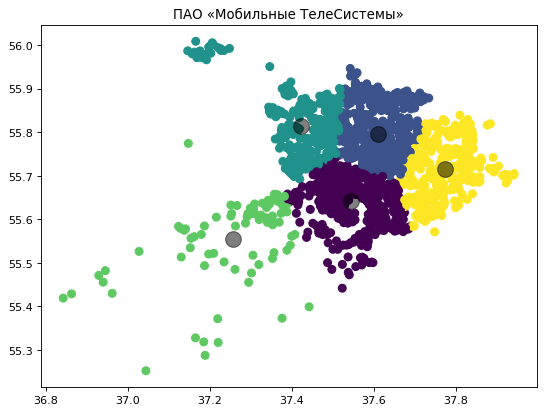

In [21]:
df_operator = df[df["Operator"] == 5]

coordinates = np.array([[row['Longitude'], row['Latitude']] for index, row in df_operator.iterrows()])

kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title("ПАО «Мобильные ТелеСистемы»")


#### Посмотрим по конкретному району

In [25]:
set(df["District"])

{'NA',
 'Академический район',
 'Алексеевский район',
 'Алтуфьевский район',
 'Бабушкинский район',
 'Басманный район',
 'Бескудниковский район',
 'Бутырский район',
 'Войковский район',
 'Гагаринский район',
 'Головинский район',
 'Даниловский район',
 'Дмитровский район',
 'Донской район',
 'Красносельский район',
 'Ломоносовский район',
 'Лосиноостровский район',
 'Мещанский район',
 'Можайский район',
 'Молжаниновский район',
 'Нагорный район',
 'Нижегородский район',
 'Обручевский район',
 'Останкинский район',
 'Пресненский район',
 'Рязанский район',
 'Савёловский район',
 'Таганский район',
 'Тверской район',
 'Тимирязевский район',
 'Хорошёвский район',
 'Южнопортовый район',
 'Ярославский район',
 'поселение "Мосрентген"',
 'поселение Внуковское',
 'поселение Вороновское',
 'поселение Воскресенское',
 'поселение Десеновское',
 'поселение Киевский',
 'поселение Кленовское',
 'поселение Кокошкино',
 'поселение Краснопахорское',
 'поселение Марушкинское',
 'поселение Михайлово-Я

Text(0.5, 1.0, 'Академический')

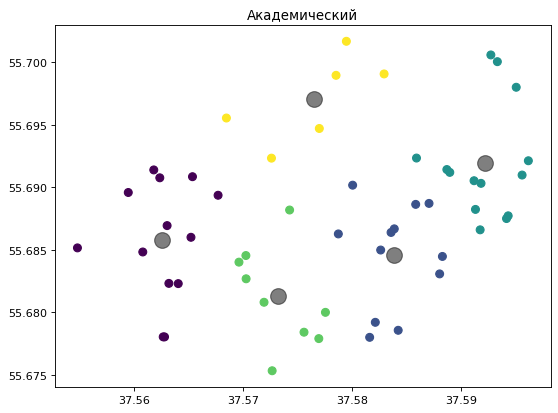

In [26]:
df_district = df[df["District"] == "Академический район"]

coordinates = np.array([[row['Longitude'], row['Latitude']] for index, row in df_district.iterrows()])

kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title("Академический")

### Привязка к оператору

In [22]:
df_district = df[df["District"] == "Академический район"]

colors = {0:"w", 1:"w", 2:"r", 3:"g", 4:"b", 5:"m"}

coordinates = np.array([[row['Longitude'], row['Latitude'], int(row['Operator'])] for index, row in df_district.iterrows()])

Text(0.5, 1.0, 'Академический')

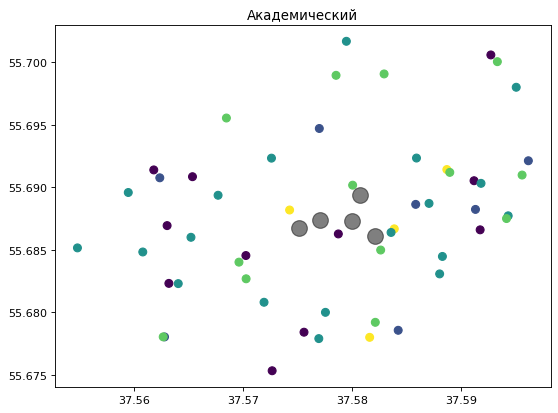

In [23]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(coordinates)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans.predict(coordinates), s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title("Академический")

### Отрисовка реальной карты

In [24]:
!pip install folium

In [25]:
!pip install geopy

In [26]:
import folium
import geopy

In [27]:
city = "Moscow"

locator = geopy.geocoders.Nominatim(user_agent="Lesson_4")
location = locator.geocode(city)
location = [location.latitude, location.longitude]

In [28]:
Moscow_map = folium.Map(location=location, zoom_start=10)

In [30]:
colors = {0:"white", 1:"white", 2:"red", 3:"green", 4:"blue", 5:"orange"}

for index, row in df_district.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = colors[row['Operator']]
    folium.CircleMarker(location=current_location, fill=True, radius = 3, color=current_color).add_to(Moscow_map)

In [34]:
Moscow_map

### Самостоятельный кейс №4

Постройте модель для ООО "Т2 Мобайл" в разбивке по df["TypeObject"]